<a href="https://colab.research.google.com/github/dwdb/tensorflow2.0-tutorial/blob/master/text/transformer_model_for_language_understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

tf.__version__

'2.2.0'

In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 40
MAX_PE_LENGTH = 200
NUM_LAYERS = 4
D_MODEL = 128
DFF = 512
NUM_HEADS = 8
DROPOUT_RATE = 0.1
EPOCHS = 20

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

In [3]:
dataset_name = 'ted_hrlr_translate/pt_to_en'
examples, meta_data = tfds.load(dataset_name, with_info=True, as_supervised=True)
train_examples, valid_examples = examples['train'], examples['validation']

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), 2 ** 13)

tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), 2 ** 13)

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete8WWBDU/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete8WWBDU/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete8WWBDU/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [0]:
def tf_encode(lang1, lang2):
    def encode(lang1, lang2):
        encoded1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
            lang1.numpy()) + [tokenizer_pt.vocab_size + 1]
        encoded2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
            lang2.numpy()) + [tokenizer_en.vocab_size + 1]
        return encoded1, encoded2

    lang1, lang2 = tf.py_function(encode, [lang1, lang2], [tf.int64, tf.int64])
    lang1.set_shape([None])
    lang2.set_shape([None])
    return lang1, lang2


def filter_max_length(x, y):
    return tf.logical_and(tf.size(x) <= MAX_LENGTH, tf.size(y) <= MAX_LENGTH)


# 保留长度较短的句子、添加起止标记、缓冲加速读取
# ！！！先map再filter，否则filter不起作用
train_dataset = train_examples \
    .map(tf_encode) \
    .filter(filter_max_length) \
    .cache() \
    .shuffle(BUFFER_SIZE) \
    .padded_batch(BATCH_SIZE, padded_shapes=([None], [None])) \
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = valid_examples \
    .map(tf_encode) \
    .filter(filter_max_length) \
    .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))

INP_VOCAB_SIZE = tokenizer_pt.vocab_size + 2
TAR_VOCAB_SIZE = tokenizer_en.vocab_size + 2

# Selt Attention

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    The transformer takes three inputs: Q (query), K (key), V (value).

    The equation used to calculate the attention weights is:
        Attention(Q, K, V) = softmax(Q·K^T/sqrt(d_k))V

    sqrt(d_k): This is done because for large valus of depth, the dot product grows large
    in magnitude pushing the softmax function where it has small gradients resulting in a
    very hard softmax.

    The mask is multiplied with 1e-9 (close to negative infinity), and large negative
    inputs to softmax are near zero in the output.

    :param q: shape=(..., seq_len, depth)
    :param k: shape=(..., seq_len, depth)
    :param v: shape=(..., seq_len, depth_v)
    :param mask: shape=(..., seq_len, seq_len)
        multi_head => (batch_size, 1, 1, seq_len), 利用广播性质mask
    """
    # (..., seq_len, seq_len)
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        # padding_mask = (batch_size, 1, 1, seq_len)
        # combined_mask = (batch_size, 1, seq_len, seq_len)
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len) so that the scores add up to 1.
    # (..., seq_len, seq_len), 对最后二维矩阵的行做归一化
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # (..., seq_len, depth_v)
    output = tf.matmul(attention_weights, v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # number of scaled dot-product attentions
        self.num_heads = num_heads
        # dimension of output
        self.d_model = d_model
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # 转置变换使得后期计算可以充分利用“广播”性质，加速计算
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k=None, q=None, mask=None):
        batch_size = tf.shape(q)[0]
        # shape=(batch_size, num_heads, seq_len, depth)
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        # scaled_attention.shape=(batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape=(batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # (batch_size, seq_len_q, d_model), d_model=num_heads*depth
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # W_O matrix, (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        return output, attention_weights

# Point wise feed forward network

In [0]:
def point_wise_feed_forward_network(d_model, dff):
    """
    Point wise feed forward network, consist of two fully-connected layers with a RELU
    activation in between.
    """
    ff_mdoel = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)])
    return ff_mdoel

# Positional Encoding

In [0]:
def positional_encoding(position, d_model):
    """
    Positional encoding is added to give the model some information about the relative
    position of the words in the sentence.

    The formula for calculating the positional encoding is as follwing:
        PE(pos,2i)   = sin(pos/10000^(2i/d_model))
        PE(pos,2i+1) = cos(pos/10000^(2i/d_model))
    """
    positions = np.arange(position)[:, np.newaxis]
    evens = np.arange(d_model)[np.newaxis, :] // 2
    angle_rates = 1 / np.power(10000, 2 * evens / np.float32(d_model))
    # shape=(seq_len, n_dimension)
    angle_rads = positions * angle_rates
    # even positions
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # odd position
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # shape=(1, position, n_dimension)
    encoding = angle_rads[np.newaxis, ...]
    return tf.cast(encoding, dtype=tf.float32)

# Mask

In [0]:
def create_padding_mask(sequence):
    """
    Mask all the pad tokens in the batch of sequence.
    It ensures that the model does not treat padding as the input.
    """
    # shape=(batch_size, seq_len)
    mask = tf.cast(tf.math.equal(sequence, 0), tf.float32)
    # shape=(batch_size, 1, 1, seq_len)
    mask = mask[:, tf.newaxis, tf.newaxis, :]
    return mask


def create_look_ahead_mask(size):
    """
    Mask the future tokens in a sequence. Used for decoding that mean the current output
    of decoder is independent of the future output.
    """
    # upper triangular matrix, shape=(seq_len, seq_len)
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask


def create_combined_mask(sequence):
    """
    创建联合掩码
    主要用于解码器输入，需同时考虑padding_mask和look_ahead_mask
    """
    look_ahead_mask = create_look_ahead_mask(tf.shape(sequence)[1])
    padding_mask = create_padding_mask(sequence)
    combined_mask = tf.maximum(padding_mask, look_ahead_mask)
    return combined_mask

# Encoder

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Each encoder layer consists of sublayers.
        1. Multi-head attention (with padding mask)
        2. Point wise feed forward networks.

    Each of these sublayers has a residual connection around it followed by a layer
    normalization. Residual connections help in avoiding the vanishing gradient problem
    in deep networks.
    """

    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        # all the shape=(batch_size, seq_len)
        attention_output, _ = self.mha(x, x, x, mask)
        attention_output = self.dropout1(attention_output, training=training)
        output1 = self.layernorm1(x + attention_output)

        ffn_output = self.ffn(output1)
        ffn_output = self.dropout2(ffn_output, training=training)
        output2 = self.layernorm2(output1 + ffn_output)
        return output2


class Encoder(tf.keras.layers.Layer):

    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, maximum_position_encoding,
                 rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.enc_layers = [
            EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :tf.shape(x)[1], :]
        x = self.dropout(x, training=training)
        for enc_layer in self.enc_layers:
            x = enc_layer(x, training, mask)
        return x

# Decoder

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, combined_mask, enc_mask):
        attn1, block1 = self.mha1(x, x, x, combined_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, block2 = self.mha2(enc_output, enc_output, out1, enc_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, block1, block2


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, maximum_position_encoding,
                 rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [
            DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, combined_mask, enc_mask):
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :tf.shape(x)[1], :]
        x = self.dropout(x, training=training)

        attention_weights = {}
        for i, dec_layer in enumerate(self.dec_layers):
            x, block1, block2 = dec_layer(x, enc_output, training, combined_mask, enc_mask)
            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        return x, attention_weights

# Transformer

In [0]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size,
                 pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size,
                               pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size,
                               pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training):
        padding_mask = create_padding_mask(inp)
        combined_mask = create_combined_mask(tar)

        # (batch_size, inp_seq_len, d_model)
        enc_output = self.encoder(inp, training, padding_mask)
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, combined_mask, padding_mask)

        # (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

# Custom Learning Rate

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        pass

In [0]:
class Translator:

    def __init__(self):
        self.transformer = Transformer(NUM_LAYERS, D_MODEL, NUM_HEADS, DFF, INP_VOCAB_SIZE,
                                       TAR_VOCAB_SIZE, MAX_PE_LENGTH, MAX_PE_LENGTH,
                                       DROPOUT_RATE)

        self.train_loss = tf.keras.metrics.Mean('train_loss')
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(True, reduction='none')
        self.learning_rate = CustomSchedule(D_MODEL)
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate, 0.9, 0.98, 1e-9)

        ckpt = tf.train.Checkpoint(transformer=self.transformer, optimizer=self.optimizer)
        self.ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints/train", 5)
        if self.ckpt_manager.latest_checkpoint:
            ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print('Latest checkpoint restored!!')

    def loss_function(self, real, pred):
        loss = self.loss_object(real, pred)
        mask = tf.cast(tf.math.logical_not(tf.math.equal(real, 0)), dtype=loss.dtype)
        loss = tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)
        return loss

    @tf.function(input_signature=train_step_signature)
    def train_step(self, inp, tar):
        tar_inp, tar_real = tar[:, :-1], tar[:, 1:]
        with tf.GradientTape() as tape:
            predictions, _ = self.transformer(inp, tar_inp, True)
            loss = self.loss_function(tar_real, predictions)

        gradients = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.transformer.trainable_variables))
        self.train_loss(loss)
        self.train_accuracy(tar_real, predictions)

    def train(self):
        for epoch in range(EPOCHS):
            start = time.time()
            self.train_loss.reset_states()
            self.train_accuracy.reset_states()

            for (batch, (inp, tar)) in enumerate(train_dataset):
                self.train_step(inp, tar)

                if batch % 50 == 0:
                    print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                        epoch + 1, batch, self.train_loss.result(), self.train_accuracy.result()))

            if (epoch + 1) % 5 == 0:
                ckpt_save_path = self.ckpt_manager.save()
                print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))

            print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, self.train_loss.result(), self.train_accuracy.result()))
            print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

    def evaluate(self, inp_sentence):
        start_token = [tokenizer_pt.vocab_size]
        end_token = [tokenizer_pt.vocab_size + 1]

        # inp sentence is portuguese, hence adding the start and end token
        inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
        encoder_input = tf.expand_dims(inp_sentence, 0)

        # as the target is english, the first word to the transformer should be the
        # english start token.
        decoder_input = [tokenizer_en.vocab_size]
        output = tf.expand_dims(decoder_input, 0)

        for i in range(MAX_LENGTH):
            predictions, attention_weights = self.transformer(encoder_input, output, False)
            # select the last word from the seq_len dimension
            predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
            # return the result if the predicted_id is equal to the end token
            if predicted_id == tokenizer_en.vocab_size + 1:
                return tf.squeeze(output, axis=0), attention_weights
            # concatentate the predicted_id to the output which is given to the decoder
            # as its input.

            output = tf.concat([output, predicted_id], axis=-1)

        return tf.squeeze(output, axis=0), attention_weights

    def translate(self, sentence, plot=False):
        result, attention_weights = self.evaluate(sentence)
        predicted_sentence = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size])
        print('Input: {}'.format(sentence))
        print('Predicted translation: {}'.format(predicted_sentence))
        if plot:
            self.plot_attention_weights(attention_weights, sentence, result, plot)

    @staticmethod
    def plot_attention_weights(attention, sentence, result, layer):
        fig = plt.figure(figsize=(16, 8))
        sentence = tokenizer_pt.encode(sentence)
        attention = tf.squeeze(attention[layer], axis=0)
        for head in range(attention.shape[0]):
            ax = fig.add_subplot(2, 4, head + 1)
            # plot the attention weights
            ax.matshow(attention[head][:-1, :], cmap='viridis')
            fontdict = {'fontsize': 10}
            ax.set_xticks(range(len(sentence) + 2))
            ax.set_yticks(range(len(result)))
            ax.set_ylim(len(result) - 1.5, -0.5)
            ax.set_xticklabels(
                ['<start>'] + [tokenizer_pt.decode([i]) for i in sentence] + ['<end>'],
                fontdict=fontdict, rotation=90)
            ax.set_yticklabels(
                [tokenizer_en.decode([i]) for i in result if i < tokenizer_en.vocab_size],
                fontdict=fontdict)
            ax.set_xlabel('Head {}'.format(head + 1))
        plt.tight_layout()
        plt.show()

In [0]:
translator = Translator()

In [19]:
translator.train()

Epoch 1 Batch 0 Loss 8.9957 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9446 Accuracy 0.0040
Epoch 1 Batch 100 Loss 8.8452 Accuracy 0.0142
Epoch 1 Batch 150 Loss 8.7388 Accuracy 0.0172
Epoch 1 Batch 200 Loss 8.6105 Accuracy 0.0188
Epoch 1 Batch 250 Loss 8.4553 Accuracy 0.0197
Epoch 1 Batch 300 Loss 8.2794 Accuracy 0.0235
Epoch 1 Batch 350 Loss 8.0924 Accuracy 0.0272
Epoch 1 Batch 400 Loss 7.9115 Accuracy 0.0300
Epoch 1 Batch 450 Loss 7.7468 Accuracy 0.0326
Epoch 1 Batch 500 Loss 7.6046 Accuracy 0.0357
Epoch 1 Batch 550 Loss 7.4719 Accuracy 0.0394
Epoch 1 Batch 600 Loss 7.3464 Accuracy 0.0432
Epoch 1 Batch 650 Loss 7.2288 Accuracy 0.0469
Epoch 1 Batch 700 Loss 7.1135 Accuracy 0.0505
Epoch 1 Loss 7.1091 Accuracy 0.0506
Time taken for 1 epoch: 96.10432004928589 secs

Epoch 2 Batch 0 Loss 5.4537 Accuracy 0.0963
Epoch 2 Batch 50 Loss 5.4867 Accuracy 0.1041
Epoch 2 Batch 100 Loss 5.4189 Accuracy 0.1063
Epoch 2 Batch 150 Loss 5.3708 Accuracy 0.1080
Epoch 2 Batch 200 Loss 5.3319 Accuracy 0.1093
Ep

In [20]:
translator.translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [21]:
translator.translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to really quickly share with you some of some magic stories that happened to happen .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book that i did it .


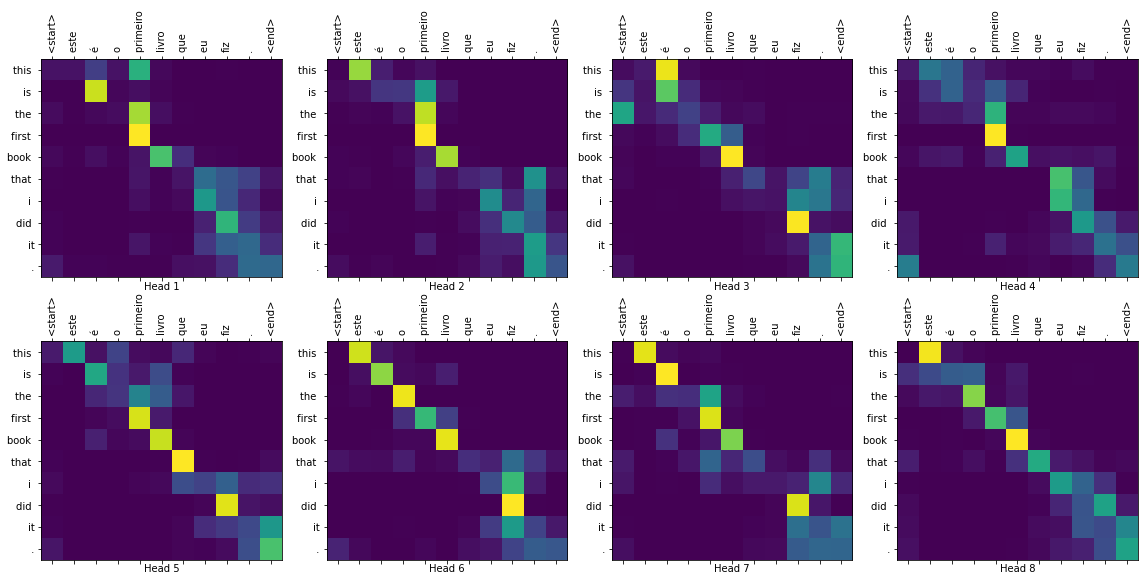

Real translation: this is the first book i've ever done.


In [23]:
translator.translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")